In [1]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)
  Using cached soundfile-0.11.0-py2.py3-none-any.whl (23 kB)
  Using cached audioread-3.0.0-py3-none-any.whl
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Using cached numba-0.53.1-cp36-cp36m-manylinux2014_x86_64.whl (3.4 MB)
  Using cached numba-0.53.0-cp36-cp36m-manylinux2014_x86_64.whl (3.4 MB)
INFO: pip is looking at multiple versions of resampy to determine which version is compatible with other requirements. This could take a while.
  Using cached resampy-0.4.1-py3-none-any.whl (3.1 MB)
  Using cached resampy-0.4.0-py3-none-any.whl (3.1 MB)
  Using cached resampy-0.3.1-py3-none-any.whl (3.1 MB)


In [3]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [4]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Librerias Utilizadas

In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment
import os
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras import optimizers
from sklearn.metrics import confusion_matrix
import seaborn as sn

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Se guardan las rutas de los 2 tipos de audio

In [6]:
normal = '/home/ec2-user/SageMaker/ACM/audio normal/'
anomalo = '/home/ec2-user/SageMaker/ACM/audio contaminado/'

Funcion para obtener el nombre de los archivos de audio

In [7]:
def contenido_audios():
    a = os.listdir(normal)
    b = os.listdir(anomalo)
    return a,b

In [8]:
c1,c2 = contenido_audios()

Funcion para obtener los metadatos de audio (File name, Channels, Sample width, Frame rate/Sample rate, Frame width, Length, Intensity)
y guardarlos como dataframe

contenido: Nombre de los audios, tipo_audio: Etiqueta a la que pertenece (normal, anomalo)

In [9]:
def metadatos(contenido,tipo_audio):
    df = pd.DataFrame()
    df['file name'] = None
    df['Channels'] = None
    df['Sample width'] = None
    df['Frame rate (sample rate)'] = None
    df['Frame width'] = None
    df['Length (seg)'] = None
    df['Frame count'] = None
    df['Intensity'] = None
    for i in range(len(contenido)):
        audio_segment = AudioSegment.from_file(tipo_audio+str(contenido[i]))
        df.loc[i] = [contenido[i],audio_segment.channels,audio_segment.sample_width,audio_segment.frame_rate,
                        audio_segment.frame_width,len(audio_segment)/1000,audio_segment.frame_count(),
                        audio_segment.dBFS]

    return df

Se obtienen los metadatos del audio normal y se le agrega al dataframe una columna llamada etiqueta con 'normal'

In [10]:
metadatos_audio_normal = metadatos(c1,normal)
metadatos_audio_normal = metadatos_audio_normal.assign(etiqueta='normal')

Se obtienen los metadatos del audio contaminado y se le agrega al dataframe una columna llamada etiqueta con 'anomalo'

In [11]:
metadatos_audio_anomalo = metadatos(c2,anomalo)
metadatos_audio_anomalo = metadatos_audio_anomalo.assign(etiqueta='anomalo')

Se juntan los 2 dataframes

In [12]:
metadatos = pd.concat([metadatos_audio_normal, metadatos_audio_anomalo], axis=0, ignore_index=True)

Preprocesamiento: Se elige el Frame_size, HOP_LENGTH, WINDOW

Ademas se deja el sample rate fijo

In [13]:
Frame_size = 1024
HOP_LENGTH = 512 
WINDOW = 'hann'
SR = 44100

Funcion donde se carga el audio, se obtiene la stft y el espectrograma, y se calcula la media de cada fila del espectrograma, luego se guarda en un dataframe

In [14]:
def feature(contenido,tipo_audio):
    df = pd.DataFrame()
    df['file name'] = None
    df['y'] = None
    df['stft'] = None
    df['Espectrograma'] = None
    df['Espectrograma scaled'] = None
    for i in range(len(contenido)):
        y, sr = librosa.load(tipo_audio+str(contenido[i]),sr=SR,mono=True)
        stft = librosa.stft(y,n_fft=Frame_size,hop_length=HOP_LENGTH,window=WINDOW)
        espectrograma = np.abs(stft)**2
        espectrograma_scaled = np.mean(espectrograma.T,axis=0)
        df.loc[i] = [contenido[i],y,stft,espectrograma,espectrograma_scaled]
    return df

Funcion para escuchar un archivo de audio

In [15]:
def escuchar_audio(y,sr):
    audio = Audio(data=y, rate=sr)
    return audio

Funcion para graficar la forma de onda (waveform)

In [16]:
def plot_waveform(y,sr):
    plt.figure(figsize = (15, 10))
    librosa.display.waveshow(y=y, sr=sr)
    plt.xlabel('Tiempo', fontsize = 15)
    plt.ylabel('Amplitud', fontsize = 15)
    plt.show()

Funcion para graficar el espectrograma (spectrogram) en escala logaritmica

In [17]:
def plot_spectrogram(spectrogram,hop_length,sr):
    plt.figure(figsize = (15, 10))
    D = librosa.power_to_db(spectrogram)
    librosa.display.specshow(D,sr=sr,hop_length=hop_length,y_axis='log',x_axis='time')
    plt.colorbar(format='%+2.f')
    plt.show()

Utilizamos la funcion feature en el audio normal y al dataframe le agregamos la columna llamada 'etiqueta' con 0

In [18]:
df_audio_normal = feature(c1,normal)
df_audio_normal = df_audio_normal.assign(etiqueta=0)

Utilizamos la funcion feature en el audio anomalo y al dataframe le agregamos la columna llamada 'etiqueta' con 1

In [20]:
df_audio_anomalo = feature(c2,anomalo)
df_audio_anomalo = df_audio_anomalo.assign(etiqueta=1)

Se juntan los 2 dataframes

In [21]:
df_audios = pd.concat([df_audio_normal, df_audio_anomalo], axis=0,ignore_index=True)

In [22]:
X=np.array(df_audios['Espectrograma scaled'].tolist())
y=np.array(df_audios['etiqueta'].tolist())

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1,stratify=y)

In [24]:
'''Dimensión del espacio de entrada:'''
input_size = X_train.shape[1]

In [25]:
num_labels = len(np.unique(y_train))

In [26]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [27]:
'''Hiperparámetros de la red:'''
batch_size = 25
hidden_units = 16
dropout = 0.3
epochs = 50

In [28]:
model = Sequential()
model.add(Dense(hidden_units, input_dim= input_size)) 
model.add(Activation('relu')) 
model.add(Dropout(dropout)) 
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                8224      
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 8,258
Trainable params: 8,258
Non-trainable params: 0
_________________________________________________________________


In [29]:
'''Configuración'''
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
%%time
'''Entrenamiento del modelo'''
history = model.fit(X_train, y_train, batch_size= batch_size, epochs= epochs, validation_data= (X_test, y_test))

Epoch 1/50
6/6 [==============================] - 0s 56ms/step - loss: 2.7829 - accuracy: 0.5473 - val_loss: 3.5011 - val_accuracy: 0.5200
Epoch 2/50
6/6 [==============================] - 0s 13ms/step - loss: 2.2809 - accuracy: 0.5338 - val_loss: 0.5555 - val_accuracy: 0.5200
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.7637 - accuracy: 0.5270 - val_loss: 0.7288 - val_accuracy: 0.5200
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.4846 - accuracy: 0.5068 - val_loss: 0.7491 - val_accuracy: 0.5200
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0176 - accuracy: 0.5203 - val_loss: 0.7649 - val_accuracy: 0.5200
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.9329 - accuracy: 0.5541 - val_loss: 0.7643 - val_accuracy: 0.5200
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0353 - accuracy: 0.5270 - val_loss: 0.7675 - val_accuracy: 0.5200
Epoch 8/50
6/6 [==============

In [31]:
'''Evaluación en el conjunto de testeo'''
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

2/2 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 0.9800

Test accuracy: 98.0%


In [32]:
predictions = model.predict(X_test)

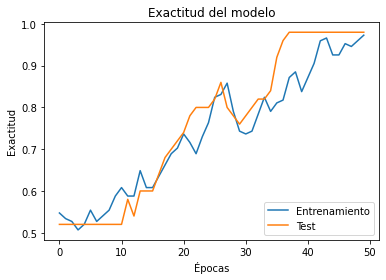

In [33]:
import matplotlib.pyplot as plt

'''Graficamos el desempeño en el conjunto de entrenamiento y testeo:'''
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Test'], loc='lower right')
plt.savefig('exactitud del modelo.jpg')
plt.show()

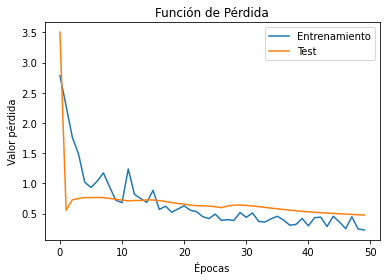

In [34]:
'''Graficamos el comportamiento de la función de pérdida:'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de Pérdida')
plt.ylabel('Valor pérdida')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Test'], loc='upper right')
plt.savefig('funcion de perdida.jpg')
plt.show()

In [35]:
y_pred = (predictions > 0.5).astype("int32")
y_pred = np.argmax(y_pred, axis= 1)

In [36]:
y_test = np.argmax(y_test, axis= 1)

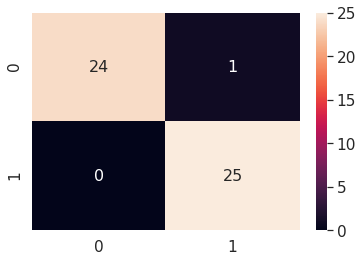

In [38]:
matrix = confusion_matrix(y_test, y_pred)
matriz = pd.DataFrame(matrix,range(2),range(2))
#plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(matriz, annot=True, annot_kws={"size": 16}) # font size

plt.savefig('matriz de confusion.jpg')
plt.show()